# pyiron_workflow concepts

In [1]:
%%time
%config IPCompleter.evaluation='unsafe'

import matplotlib.pylab as plt
from pyiron_workflow.workflow import Workflow
from pyiron_workflow.function import single_value_node

CPU times: user 1.24 s, sys: 305 ms, total: 1.55 s
Wall time: 578 ms


## Phonopy example

In [2]:
%%time
wf = Workflow('phonopy')
wf.register('atomistic', 'pyiron_workflow.node_library.atomistic')

CPU times: user 5.63 s, sys: 1.06 s, total: 6.69 s
Wall time: 16.8 s


In [3]:
wf = Workflow('test')
wf.structure = wf.create.atomistic.structure.build.bulk('Al')

In [4]:
@Workflow.wrap_as.macro_node("structure")
def bulk_rotation(wf, name='Al', cubic: bool=True, repeat_cell=2, angle=0, axis=[0,0,1]):
    wf.structure = wf.create.atomistic.structure.build.bulk(name=name, cubic=cubic)
    wf.repeat = wf.create.atomistic.structure.transform.repeat(structure=wf.structure, repeat_scalar=repeat_cell)
    wf.rotate = wf.create.atomistic.structure.transform.rotate_axis_angle(structure=wf.repeat, angle=angle, axis=axis)
    return wf.rotate

In [5]:
br = bulk_rotation()
br.structure.inputs.name.value, br.structure.inputs.cubic.value

(pyiron_workflow.channels.NotData, False)

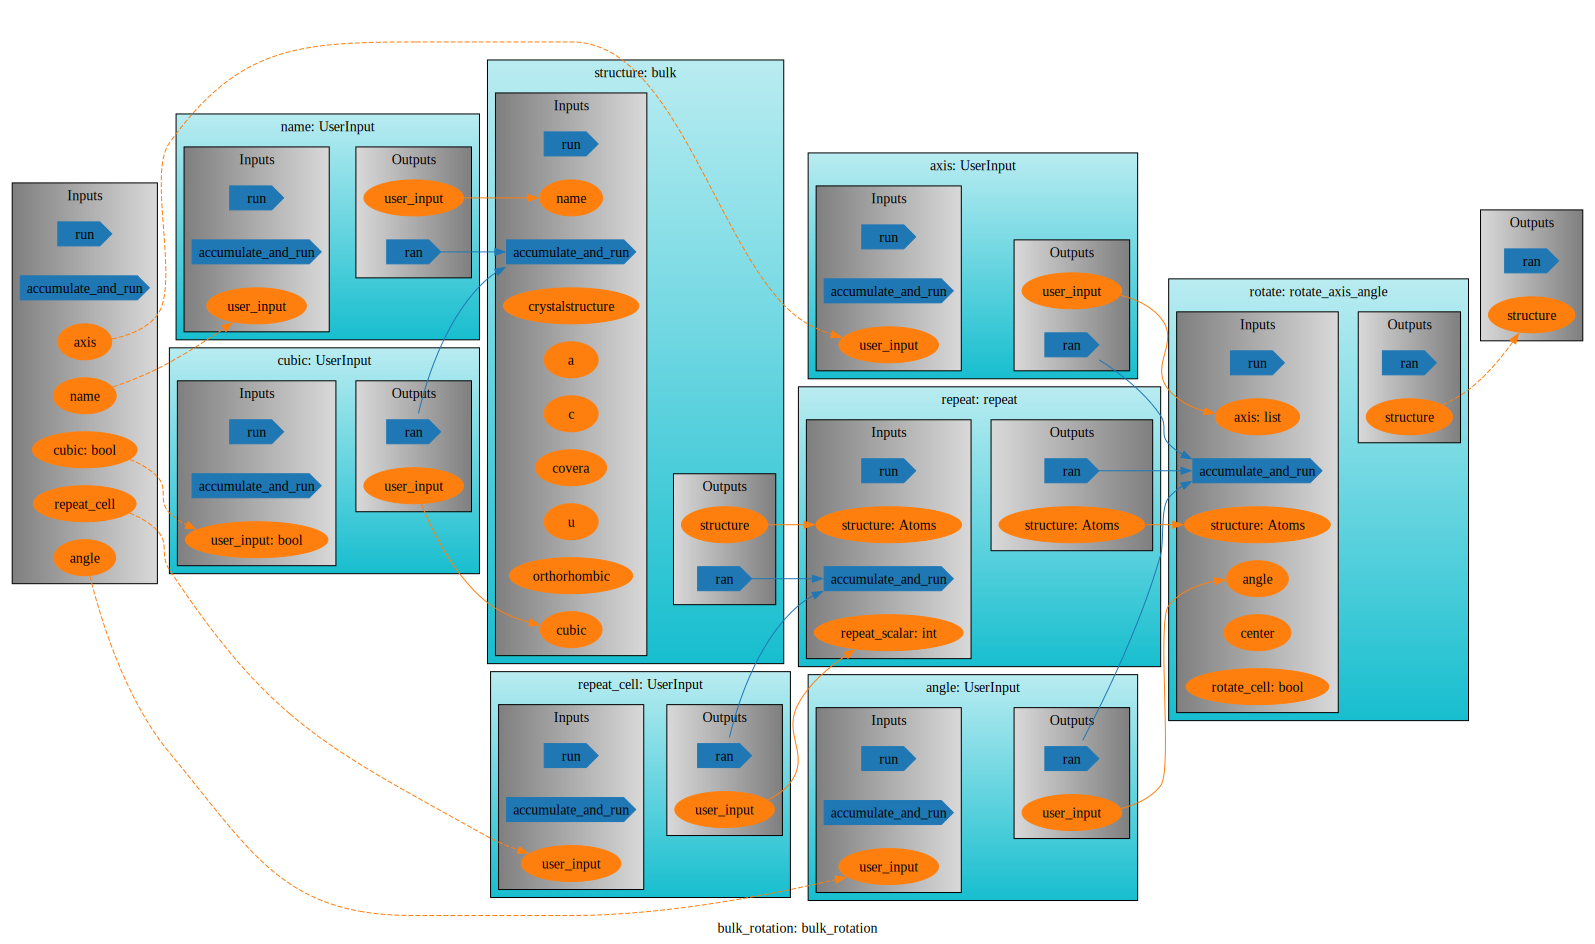

In [6]:
br.draw()

In [7]:
br.inputs.name

In [8]:
br = bulk_rotation(name='Fe')
br.structure.inputs.name = 'Al'
br.inputs.name = 'Al'
br.run()

{'structure': Al: [0. 0. 0.]
 Al: [0.    2.025 2.025]
 Al: [2.025 0.    2.025]
 Al: [2.025 2.025 0.   ]
 Al: [0.   0.   4.05]
 Al: [0.    2.025 6.075]
 Al: [2.025 0.    6.075]
 Al: [2.025 2.025 4.05 ]
 Al: [0.   4.05 0.  ]
 Al: [0.    6.075 2.025]
 Al: [2.025 4.05  2.025]
 Al: [2.025 6.075 0.   ]
 Al: [0.   4.05 4.05]
 Al: [0.    6.075 6.075]
 Al: [2.025 4.05  6.075]
 Al: [2.025 6.075 4.05 ]
 Al: [4.05 0.   0.  ]
 Al: [4.05  2.025 2.025]
 Al: [6.075 0.    2.025]
 Al: [6.075 2.025 0.   ]
 Al: [4.05 0.   4.05]
 Al: [4.05  2.025 6.075]
 Al: [6.075 0.    6.075]
 Al: [6.075 2.025 4.05 ]
 Al: [4.05 4.05 0.  ]
 Al: [4.05  6.075 2.025]
 Al: [6.075 4.05  2.025]
 Al: [6.075 6.075 0.   ]
 Al: [4.05 4.05 4.05]
 Al: [4.05  6.075 6.075]
 Al: [6.075 4.05  6.075]
 Al: [6.075 6.075 4.05 ]
 tags: 
     indices: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 pbc: [ True  True  True]
 cell: 
 Cell([8.1, 8.1, 8.1])}

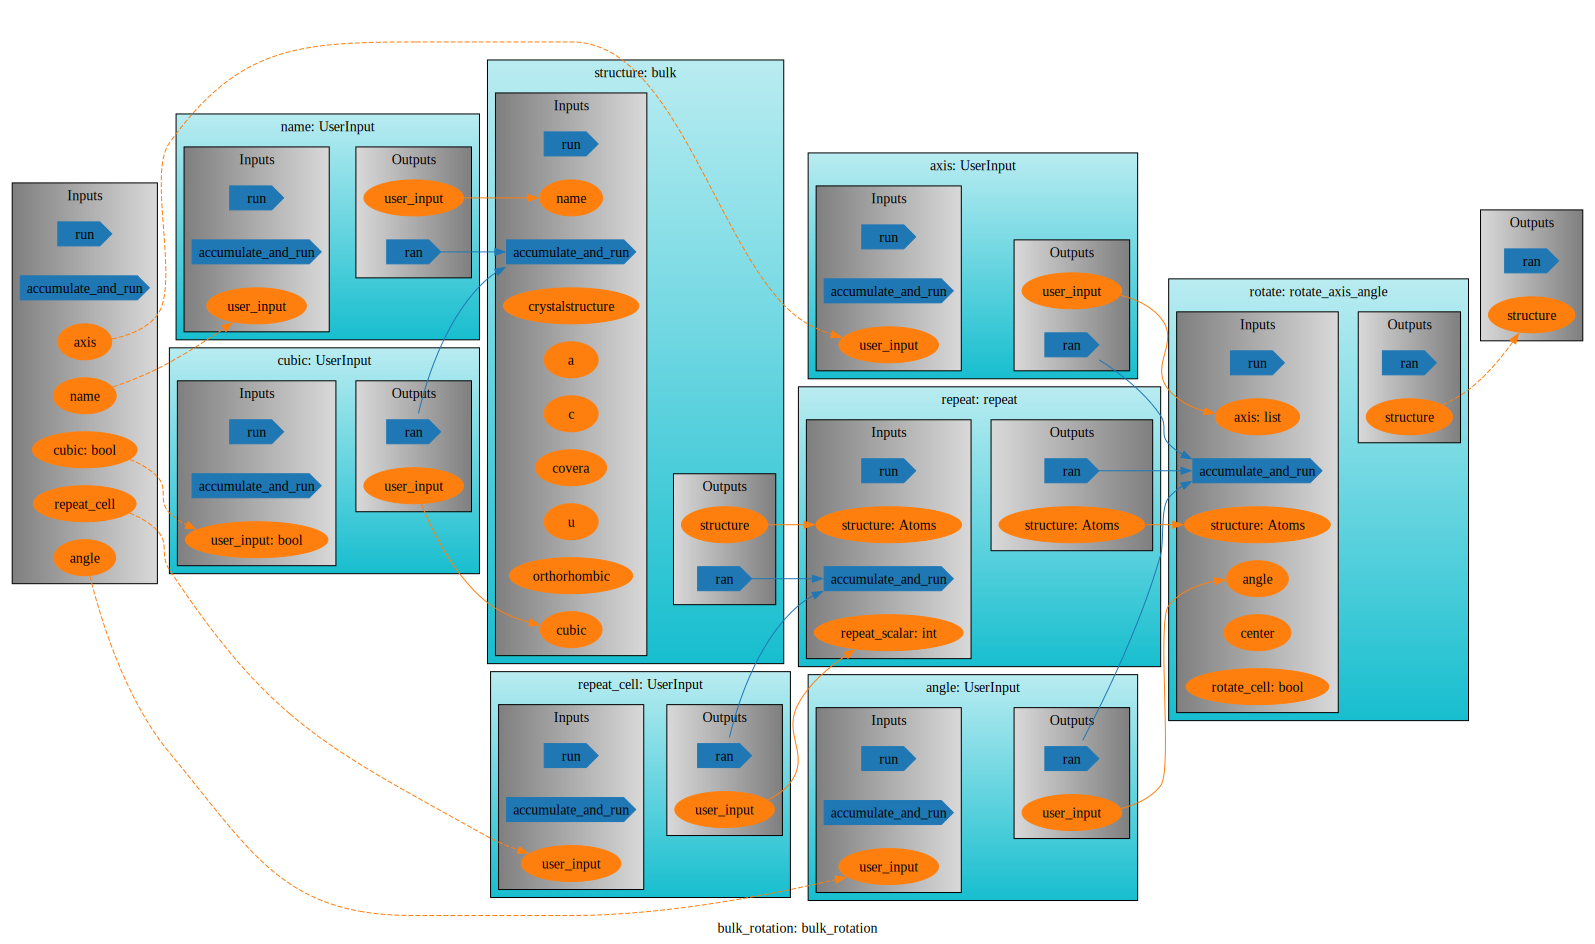

In [9]:
br.draw()

In [10]:
from pyiron_workflow.node_library.atomistic.property.phonons import InputPhonopyGenerateSupercells

### Create phonopy workflow macro

Select input and output parameters in which users may be particularly interested, i.e., over which you want to do a parameter study (input) and the quantities you want to analyse (output)

In [11]:
@Workflow.wrap_as.macro_node(
    "imaginary_modes",
    "total_dos",
    "energy_relaxed",
    "energy_initial",
    "energy_displaced",
)
def run_phonopy(
    wf,
    element: str,
    cell_size: int = 2,
    vacancy_index: int | None = None,
    displacement: float = 0.01,
    max_workers: int = 1
):

    # wf.engine = wf.create.engine.ase.M3GNet()
    wf.engine = wf.create.atomistic.engine.ase.EMT()
    
    wf.structure = wf.create.atomistic.structure.build.cubic_bulk_cell(
        element=element, cell_size=cell_size, vacancy_index=vacancy_index
    )
    # explicit output needed since macro and not single_value_node (we should have also a single_value_macro)
    wf.relaxed_structure = wf.create.atomistic.calculator.ase.minimize(
        atoms=wf.structure.outputs.structure,
        engine=wf.engine,
    )

    wf.phonopy = wf.create.atomistic.property.phonons.create_phonopy(
        structure=wf.relaxed_structure.outputs.structure,
        parameters=InputPhonopyGenerateSupercells(distance=displacement.run()),
        engine=wf.engine,
        max_workers=max_workers,
    )
    # print ('test: ', displacement.run())

    wf.check_consistency = wf.create.atomistic.property.phonons.check_consistency(
        phonopy=wf.phonopy.outputs.phonopy
    )
    wf.total_dos = wf.create.atomistic.property.phonons.get_total_dos(phonopy=wf.phonopy.outputs.phonopy)

    # iterate over all nodes, extract the log_output and store it in hdf5
    # control the amount of output via log_level

    return (
        wf.check_consistency,
        wf.total_dos,
        wf.relaxed_structure.outputs.out.final.energy,
        wf.relaxed_structure.outputs.out.initial.energy,
        wf.phonopy.outputs.out["energies"],
    )

#### Run for a single parameter set

In [12]:
%%time
wf = run_phonopy(element='Al', cell_size=3, vacancy_index=0, displacement=0.1, max_workers=1)
out = wf.run()

energy:  0.8013167095855369 0.7996059979144441
max_workers:  1
CPU times: user 6.96 s, sys: 296 ms, total: 7.25 s
Wall time: 2.75 s


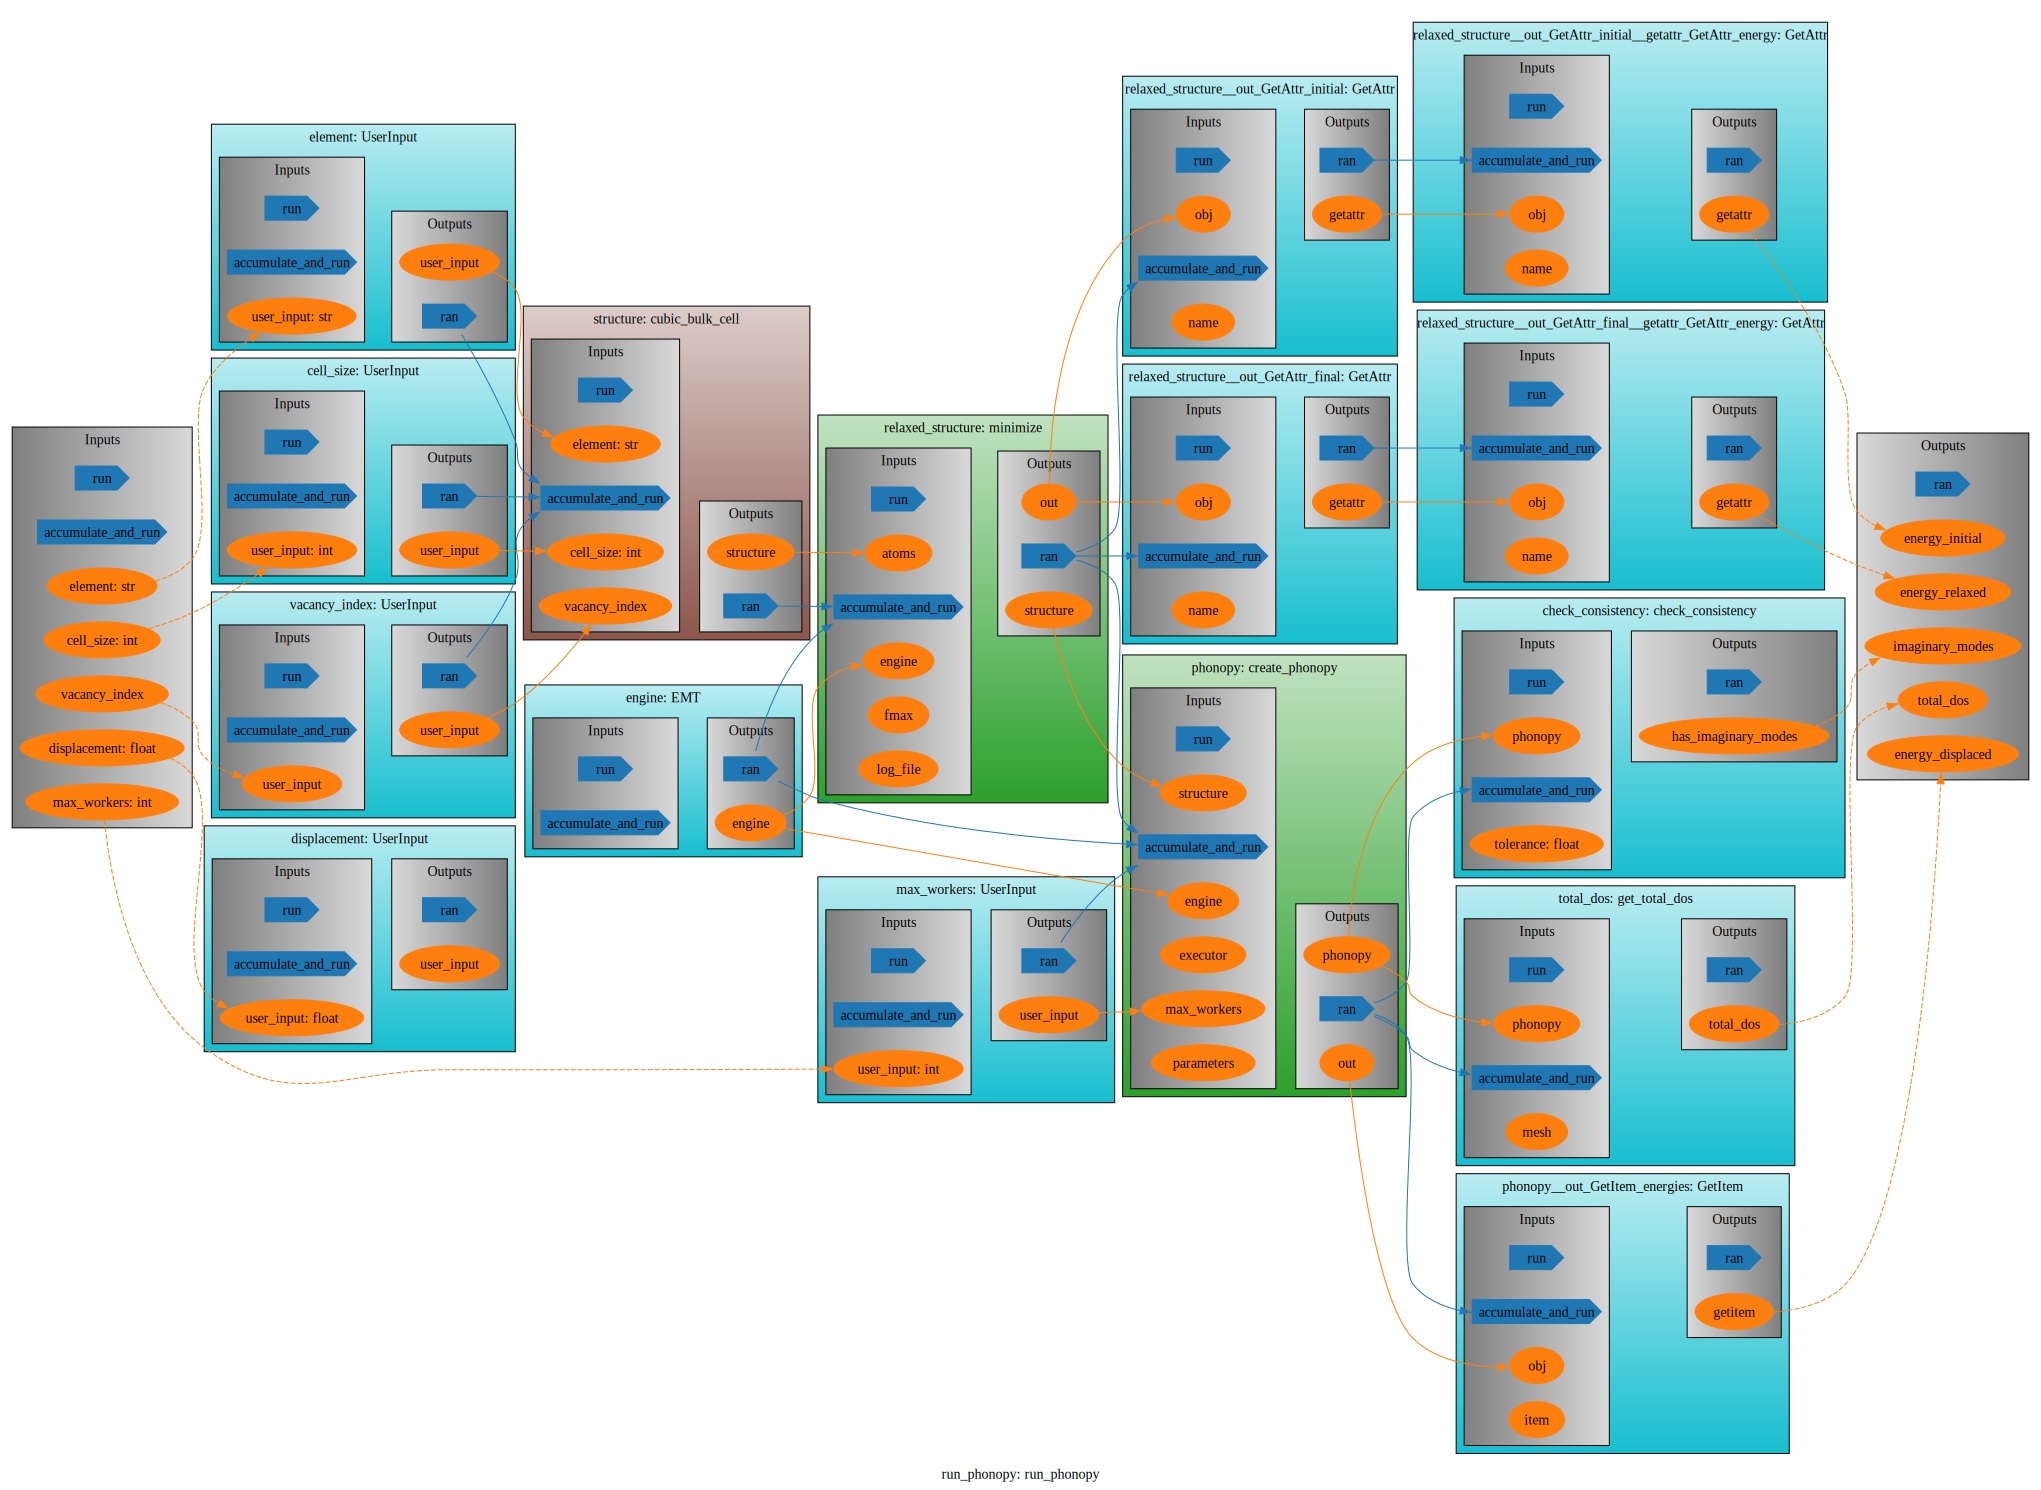

In [13]:
wf.draw()

In [14]:
import pandas as pd

In [15]:
wf.phonopy.outputs.out.value['df']

,atoms,energy_pot,force,stress,structure,atomic_energies,energy,forces
0,"(Atom('Al', [12.157071067811865, 2.01846947349...",None,None,None,None,None,0.801477,"[[-0.023172401218313952, -0.02070281808992324,..."
1,"(Atom('Al', [12.14292893218813, 2.004327337874...",None,None,None,None,None,0.801456,"[[0.023223919284411358, 0.017716773608982852, ..."
2,"(Atom('Al', [12.149999999999997, 2.01139840568...",None,None,None,None,None,0.801444,"[[-0.00014853410845676318, -0.0045937310507214..."
3,"(Atom('Al', [12.149999999999997, 2.01139840568...",None,None,None,None,None,0.801514,"[[0.00017067251835383226, 0.001684919320568755..."
4,"(Atom('Al', [12.149999999999997, 2.01139840568...",None,None,None,None,None,0.801395,"[[8.120943302261999e-05, -0.001404462986399669..."
5,"(Atom('Al', [12.149999999999997, 2.01139840568...",None,None,None,None,None,0.801562,"[[-8.291373797127133e-05, -0.00156522675623289..."
6,"(Atom('Al', [12.149999999999997, 2.01139840568...",None,None,None,None,None,0.801523,"[[0.004142511131204099, -0.0014405213332471072..."
7,"(Atom('Al', [12.149999999999997, 2.01139840568...",None,None,None,None,None,0.801430,"[[-0.00423484191023942, -0.0015285012861156674..."
8,"(Atom('Al', [12.149999999999997, 2.01139840568...",None,None,None,None,None,0.801585,"[[0.004360899946174978, -0.0014522923481744762..."
9,"(Atom('Al', [12.149999999999997, 2.01139840568...",None,None,None,None,None,0.801368,"[[-0.004498869592222, -0.0015165812487091986, ..."


#### Run iteratively over several input parameters and construct a pandas table

In [16]:
%%time
df = wf.iter(cell_size=list(range(1,4)), 
             element=['Al'], 
             vacancy_index=[None, 0], 
             displacement=[0.01, 0.1]
            ) #, Cu, Pd, Ag, Pt and Au])

max_workers:  1
energy:  -0.006008190344925168 -0.006008190344925168
max_workers:  1
energy:  -0.006008190344925168 -0.006008190344925168
max_workers:  1
energy:  0.8712882553372374 0.8712882553372374
max_workers:  1
energy:  0.8712882553372374 0.8712882553372374
max_workers:  1
energy:  -0.0480655227588862 -0.0480655227588862
max_workers:  1
energy:  -0.0480655227588862 -0.0480655227588862
max_workers:  1
energy:  0.9186046985116931 0.9179414222257574
max_workers:  1
energy:  0.9186046985116931 0.9179414222257574
max_workers:  1
energy:  -0.16222113933213578 -0.16222113933213578
max_workers:  1
energy:  -0.16222113933213578 -0.16222113933213578
max_workers:  1
energy:  0.8013167095855369 0.7996059979144441
max_workers:  1
energy:  0.8013167095855369 0.7996059979144441
max_workers:  1
CPU times: user 32.1 s, sys: 1.19 s, total: 33.3 s
Wall time: 11.1 s


In [17]:
df

,cell_size,element,vacancy_index,displacement,imaginary_modes,total_dos,energy_relaxed,energy_initial,energy_displaced
0,1,Al,NaN,0.01,False,frequency_points total_dos 0 ...,-0.006008,-0.006008,"0 -0.005843 Name: energy, dtype: float64"
1,1,Al,NaN,0.10,False,frequency_points total_dos 0 ...,-0.006008,-0.006008,"0 -0.005843 Name: energy, dtype: float64"
2,1,Al,0.0,0.01,True,frequency_points total_dos 0 ...,0.871288,0.871288,"0 0.871408 Name: energy, dtype: float64"
3,1,Al,0.0,0.10,True,frequency_points total_dos 0 ...,0.871288,0.871288,"0 0.871408 Name: energy, dtype: float64"
4,2,Al,NaN,0.01,False,frequency_points total_dos 0 -...,-0.048066,-0.048066,"0 -0.047905 Name: energy, dtype: float64"
5,2,Al,NaN,0.10,False,frequency_points total_dos 0 -...,-0.048066,-0.048066,"0 -0.047905 Name: energy, dtype: float64"
6,2,Al,0.0,0.01,True,frequency_points total_dos 0 -...,0.918605,0.917941,0 0.918776 1 0.918736 2 0.918768 3 ...
7,2,Al,0.0,0.10,True,frequency_points total_dos 0 -...,0.918605,0.917941,0 0.918776 1 0.918736 2 0.918768 3 ...
8,3,Al,NaN,0.01,False,frequency_points total_dos 0 -...,-0.162221,-0.162221,"0 -0.162061 Name: energy, dtype: float64"
9,3,Al,NaN,0.10,False,frequency_points total_dos 0 -...,-0.162221,-0.162221,"0 -0.162061 Name: energy, dtype: float64"


### Elasticity

In [18]:
%%time
%config IPCompleter.evaluation='unsafe'

import matplotlib.pylab as plt
from pyiron_workflow.workflow import Workflow

import matplotlib.pylab as plt
import numpy as np

CPU times: user 3.76 ms, sys: 416 µs, total: 4.18 ms
Wall time: 1.05 ms


In [19]:
%time
wf = Workflow('phonopy')
wf.register('atomistic', 'pyiron_workflow.node_library.atomistic')
# wf.register('structure', 'pyiron_workflow.node_library.structure')
# wf.register('calculator', 'pyiron_workflow.node_library.calculator')
# wf.register('engine', 'pyiron_workflow.node_library.engine')
# wf.register('phonopy', 'pyiron_workflow.node_library.phonopy')
wf.register('databases', 'pyiron_workflow.node_library.databases')
#wf.register('property', 'pyiron_workflow.node_library.property')

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 4.05 µs


In [20]:
wf = Workflow('elastic')
wf.data = wf.create.databases.elasticity.de_jong()

In [21]:
%%time
df_data = wf.run()['data__dataframe']

CPU times: user 12 s, sys: 778 ms, total: 12.8 s
Wall time: 3.6 s


In [22]:
df_data

,G_Reuss,G_VRH,G_Voigt,K_Reuss,K_VRH,K_Voigt,compliance_tensor,elastic_anisotropy,elastic_tensor,elastic_tensor_original,formula,kpoint_density,material_id,nsites,poisson_ratio,poscar,space_group,structure,volume,atoms
0,96.844535,97.141604,97.438674,194.267623,194.268884,194.270146,"[[0.004385293093993, -0.0016070693558990002, -...",0.030688,"[[311.33514638650246, 144.45092552856926, 126....","[[311.33514638650246, 144.45092552856926, 126....",Nb4CoSi,7000,mp-10003,12,0.285701,Nb8 Co2 Si2\n1.0\n6.221780 0.000000 0.000000\n...,124,#\#CIF1.1\n###################################...,194.419802,"(Atom('Nb', [0.94814320435623, 2.0728045157580..."
1,93.939650,96.252006,98.564362,173.647763,175.449907,177.252050,"[[0.0037715428949660003, -0.000844229828709, -...",0.266910,"[[306.93357350984974, 88.02634955100905, 105.6...","[[306.93357350984974, 88.02634955100905, 105.6...",Al(CoSi)2,7000,mp-10010,5,0.268105,Al1 Co2 Si2\n1.0\n3.932782 0.000000 0.000000\n...,164,#\#CIF1.1\n###################################...,61.987320,"(Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('C..."
2,120.962289,130.112955,139.263621,295.077545,295.077545,295.077545,"[[0.0019959391925840004, -0.000433146670736000...",0.756489,"[[569.5291276937579, 157.8517489654999, 157.85...","[[569.5291276937579, 157.8517489654999, 157.85...",SiOs,7000,mp-10015,2,0.307780,Si1 Os1\n1.0\n2.960692 0.000000 0.000000\n0.00...,221,#\#CIF1.1\n###################################...,25.952539,"(Atom('Si', [1.4803461749999998, 1.48034617499..."
3,12.205989,15.101901,17.997812,49.025963,49.130670,49.235377,"[[0.021647143908635, -0.005207263618160001, -0...",2.376805,"[[69.28798774976904, 34.7875015216915, 37.3877...","[[70.13259066665267, 40.60474945058445, 37.387...",Ga,7000,mp-10021,4,0.360593,Ga4\n1.0\n2.803229 0.000000 0.000000\n0.000000...,63,#\#CIF1.1\n###################################...,76.721433,"(Atom('Ga', [0.0, 1.09045796233546, 0.84078379..."
4,100.110773,101.947798,103.784823,255.055257,256.768081,258.480904,"[[0.00410214297725, -0.001272204332729, -0.001...",0.196930,"[[349.3767766177825, 186.67131003104407, 176.4...","[[407.4791016459293, 176.4759188081947, 213.83...",SiRu2,7000,mp-10025,12,0.324682,Si4 Ru8\n1.0\n4.037706 0.000000 0.000000\n0.00...,62,#\#CIF1.1\n###################################...,160.300999,"(Atom('Si', [1.0094264625, 4.247717077057611, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,43.697362,53.329789,62.962216,110.397752,111.788114,113.178476,"[[0.0044568832753350005, -0.001136458158149, -...",2.229538,"[[250.07723993082595, 71.61036453717465, 44.31...","[[250.07723993082595, 71.61036453717465, 44.31...",Ti2CdC,7000,mp-9961,8,0.294196,Ti4 Cd2 C2\n1.0\n3.103427 0.000000 0.000000\n-...,194,#\#CIF1.1\n###################################...,121.520152,"(Atom('Ti', [1.5517152117138742, 0.89588144411..."
1177,66.067578,70.253182,74.438787,101.207608,101.326807,101.446005,"[[0.007188192080993001, -0.000983458215036, -0...",0.635889,"[[172.01931871370775, 43.38593006033102, 76.22...","[[172.01931871370775, 43.38593006033102, 76.22...",ScSi,7000,mp-9969,8,0.218412,Sc4 Si4\n1.0\n3.996960 0.000000 0.000000\n0.00...,63,#\#CIF1.1\n###################################...,145.392095,"(Atom('Sc', [0.0, 8.534175787117318, 0.9174096..."
1178,62.326766,65.160458,67.994149,89.416354,89.418161,89.419968,"[[0.007749056578454001, -0.001293580144074, -0...",0.454691,"[[159.44792354820547, 42.19645554837514, 66.58...","[[159.44792354820547, 42.19645554837514, 66.58...",YSi,7000,mp-9972,8,0.206850,Y4 Si4\n1.0\n4.286685 0.000000 0.000000\n0.000...,63,#\#CIF1.1\n###################################...,174.123748,"(Atom('Y', [0.0, 9.084548591046719, 0.96092093..."
1179,37.457129,40.211802,42.966475,99.383115,99.384565,99.386015,"[[0.007456839159427001, -0.002592061077082, -0...",0.735449,"[[170.12510286354689, 70.6116049091726, 57.026...","[[170.12510286354689, 70.6116049091726, 57.026...",Al2Cu,7000,mp-998,12,0.321738,Al8 Cu4\n1.0

In [23]:
unaries = df_data[df_data.formula.str.len() == 2]
K_Reuss = unaries.K_Reuss.values
K_Voigt = unaries.K_Voigt
structures = unaries.atoms.values

Note: 
- Different symbols/terms for identical physical quantities would be a nice example for application of ontology
- ChatGPT could be used to analyze data (where is agreement good, where not)

In [24]:
table_M3GNet = Workflow.create.atomistic.structure.calc.volume().iter(structure=structures)  # TODO: load rather than run

max_workers:  1
iter: add label


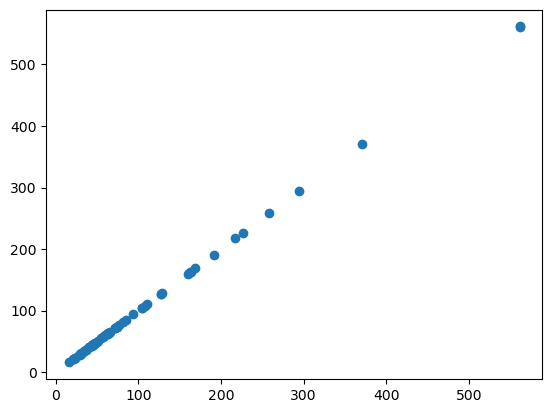

In [25]:
plt.scatter(unaries.volume, table_M3GNet.volume);

In [26]:
%%time
import warnings
warnings.filterwarnings("ignore")

out = Workflow.create.atomistic.property.elastic.elastic_constants().iter(structure=structures)

max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_workers:  1
max_work

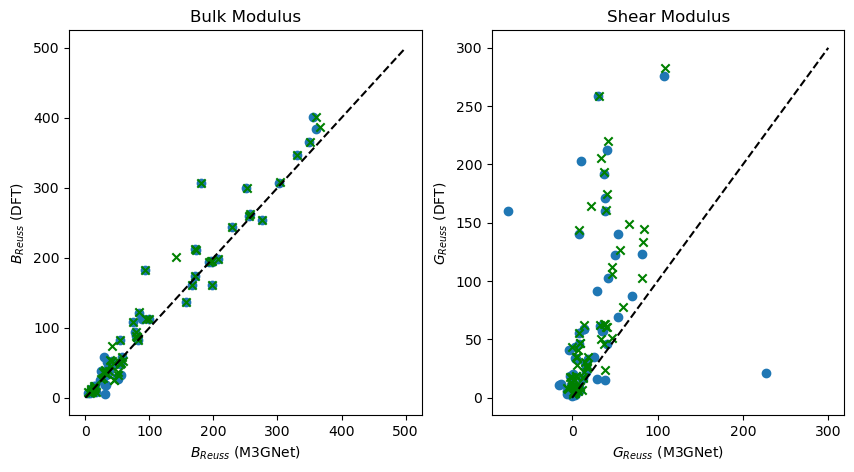

In [27]:
x = np.linspace(0, 500, 101)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(out.BR, unaries.K_Reuss)
plt.scatter(out.BV, unaries.K_Voigt, c='g', marker = 'x')
plt.xlabel('$B_{Reuss}$ (M3GNet)')
plt.ylabel('$B_{Reuss}$ (DFT)')
plt.title('Bulk Modulus')
plt.plot(x, x, 'k--');

plt.subplot(1,2,2)
x = np.linspace(0, 300, 101)

plt.scatter(out.GR, unaries.G_Reuss)
plt.scatter(out.GV, unaries.G_Voigt, c='g', marker = 'x')
plt.xlabel('$G_{Reuss}$ (M3GNet)')
plt.ylabel('$G_{Reuss}$ (DFT)')
plt.title('Shear Modulus')
plt.plot(x, x, 'k--');

In [28]:
unaries.keys()

Index(['G_Reuss', 'G_VRH', 'G_Voigt', 'K_Reuss', 'K_VRH', 'K_Voigt',
       'compliance_tensor', 'elastic_anisotropy', 'elastic_tensor',
       'elastic_tensor_original', 'formula', 'kpoint_density', 'material_id',
       'nsites', 'poisson_ratio', 'poscar', 'space_group', 'structure',
       'volume', 'atoms'],
      dtype='object')

In [29]:
xx

NameError: name 'xx' is not defined

### Test universal ML potential

In [ ]:
from ase import units
from ase.build import bulk
from atomistics.calculators import calc_molecular_dynamics_langevin_with_ase

In [ ]:
import matgl
from matgl.ext.ase import M3GNetCalculator

In [ ]:
%%time
structure = bulk("Al", cubic=True).repeat([3, 3, 3])
ase_calculator = M3GNetCalculator(matgl.load_model("M3GNet-MP-2021.2.8-PES"))
result_dict = calc_molecular_dynamics_langevin_with_ase(
    structure=structure,
    ase_calculator=ase_calculator,
    run=1000,
    thermo=10,
    timestep=1 * units.fs,
    temperature=1000,
    friction=0.002,
)

In [ ]:
result_dict.keys()

In [ ]:
plt.plot(result_dict['energy_pot']);

In [ ]:
plt.plot(result_dict['positions'][:,:,0]);

In [ ]:
from pyiron_workflow.node_library.dev_tools import Output

In [ ]:
# Example usage:
def get_energy(arg1, arg2):
    #print(f"Function 1 called with arguments: {arg1}, {arg2}")
    return arg1 + arg2

def function2(arg1, arg2):
    print(f"Function 2 called with arguments: {arg1}, {arg2}")
    return f"Hello, {arg1} {arg2}!"

def function3(arg):
    print(f"Function 3 called with argument: {arg}")
    return [i for i in range(arg)]

def to_dict(func, args=(), kwargs={}):
    return (func, args, kwargs)

output = Output(keys_to_run=['energy'])
print ('keys to run: ', output._keys_to_run)
output['energy'] = to_dict(get_energy, args=(3, 2))

output.run()

# Iterating over keys and values
for key, value in output.items():
    print(f"{key}: {value}")

In [ ]:
'energy' in output._functions

In [ ]:
func, args, kwargs = output._functions['energy']

In [ ]:
func, args, kwargs = to_dict(get_energy, args=(3, 2))

In [ ]:
func(*args)

In [ ]:
output._functions['energy']

In [ ]:
func(*args, **kwargs)

In [ ]:
class LazyDict:
    def __init__(self, **kwargs):
        self._functions = {key: (value['func'], value.get('args', ()), value.get('kwargs', {})) for key, value in kwargs.items()}

    def __getitem__(self, key):
        if key not in self._functions:
            raise KeyError(f"Key '{key}' not found.")
        func, args, kwargs = self._functions[key]
        return func(*args, **kwargs)

    def __setitem__(self, key, value):
        func, args, kwargs = value
        self._functions[key] = (func, args, kwargs)

    def __delitem__(self, key):
        if key in self._functions:
            del self._functions[key]

    def keys(self):
        return list(self._functions.keys())

    def values(self):
        return [self[key] for key in self.keys()]

    def items(self):
        return [(key, self[key]) for key in self.keys()]

    def run(self, keys_to_run):
        for key in keys_to_run:
            if key in self._functions:
                self[key]

# Example usage:
def function1(arg1, arg2):
    print(f"Function 1 called with arguments: {arg1}, {arg2}")
    return arg1 + arg2

def function2(arg1, arg2):
    print(f"Function 2 called with arguments: {arg1}, {arg2}")
    return f"Hello, {arg1} {arg2}!"

def function3(arg):
    print(f"Function 3 called with argument: {arg}")
    return [i for i in range(arg)]

lazy_dict = LazyDict(
    key1={'func': function1, 'args': (3, 4), 'kwargs': {}},
    key2={'func': function2, 'args': ('John', 'Doe'), 'kwargs': {}},
    key3={'func': function3, 'args': (5,), 'kwargs': {}},
)

# Accessing values triggers function evaluation with arguments
print(lazy_dict['key1'])  # Output: Function 1 called with arguments: 3, 4 7
print(lazy_dict['key2'])  # Output: Function 2 called with arguments: John, Doe Hello, John Doe!
print(lazy_dict['key3'])  # Output: Function 3 called with argument: 5 [0, 1, 2, 3, 4]

# Adding a new key-value pair with arguments
#lazy_dict['key4'] = (lambda x, y: x * y, (2, 3), {})
lazy_dict['key4'] = (function1,  (3, 4),  {})
print(lazy_dict['key4'])  # Output: 6

# Run specific functions
lazy_dict.run(['key1', 'key2'])
# Output:
# Function 1 called with arguments: 3, 4
# Function 2 called with arguments: John, Doe

# Iterating over keys and values
for key, value in lazy_dict.items():
    print(f"{key}: {value}")

In [ ]:
from phonopy.api_phonopy import Phonopy
from pyiron_workflow.node_library.dev_tools import wf_data_class

from typing import Optional, Union

In [ ]:
@wf_data_class(doc_func=Phonopy.generate_displacements)
class InputPhonopyGenerateSupercells:
    distance: float = 0.01
    is_plusminus: Union[str, bool] = "auto"
    is_diagonal: bool = True
    is_trigonal: bool = False
    number_of_snapshots: Optional[int] = None
    random_seed: Optional[int] = None
    temperature: Optional[float] = None
    cutoff_frequency: Optional[float] = None
    max_distance: Optional[float] = None    

In [ ]:
par = InputPhonopyGenerateSupercells(max_distance=10)
par['distance'] = 1

In [ ]:
par

In [ ]:
par.distance

In [ ]:
par??

In [ ]:
par.distances=0.2

In [ ]:
par.select(keys_to_store=['distance'])

In [ ]:
def test(**kwargs):
    for a in kwargs.items():
        print (a)

In [ ]:
test(**par.select(keys_to_store=['distance']))

In [ ]:
test(**par)

In [ ]:
from ase import Atoms, build

In [ ]:
Al = build.bulk('Al', cubic=True)
Al.get_positions(wrap=True)

In [ ]:
Al.get_stress()

In [ ]:
Al.get_

In [ ]:
from dataclasses import dataclass

@dataclass
class Address:
    street: str
    city: str
    zip_code: str

@dataclass
class Person:
    name: str
    age: int
    address: Address = Address(street='', city='', zip_code='')

# Example usage
person_with_default_address = Person(name='John Doe', age=30)

# Accessing the default address
print(person_with_default_address.address)

In [ ]:
from dataclasses import dataclass, field

@dataclass
class Address:
    street: str
    city: str
    zip_code: str

@dataclass
class Person:
    name: str
    age: int
    address: Address = field(default_factory=lambda: Address(street='', city='', zip_code=''))

# Example usage
person_with_default_address = Person(name='John Doe', age=30)

# Accessing the default address
print(person_with_default_address.address)

### Pseudocode for output class

In [ ]:
from typing import Optional, Union
from typing import Callable, TypeVar, Any, TypeAlias
from dataclasses import dataclass

import numpy as np

In [ ]:
@dataclass
class VarFunc:
    func: Callable = None
    log_level: int = 0
    unit: str = ''

In [ ]:
@dataclass
class VarType:
    property: TypeVar = None
    log_level: int = 0
    unit: str = ''

In [ ]:
VarFunc(func=np.sin, log_level=2).func

In [ ]:
class toy_job:
    def __init__(self, x=0):
        self.x = x

    def get_energy(self):
        return np.sin(self.x)

    def get_forces(self):
        return np.ones(3)

    @property
    def my_x(self):
        return self.x

In [ ]:
job = toy_job(1)
job.get_energy(), job.get_forces()

In [ ]:
@dataclass
class wfOutput:
    pass

    def keys(self):
        return self.__dict__.keys()

    def __getitem__(self, key):
        return self.__dict__[key]    

    def __call__(self, job):
        out_dict = dict()
        for key in self.keys():
            print (key)
            v = self[key]
            if isinstance(v, VarFunc):
                out_dict[key] = job.__getattribute(job)()
                
        return out_dict       

In [ ]:
import pint
ureg = pint.UnitRegistry()
ureg.angstrom

In [ ]:
# import ase
import pint

@dataclass
class OutputEnergyStatic:
    distance: float = 0.01
    energy: VarFunc = VarFunc(func=toy_job.get_energy, log_level=0, unit=ureg.eV)
    forces: VarFunc = VarFunc(func=toy_job.get_forces, log_level=1, unit=ureg.eV/ureg.angstrom)
    prop: VarType = VarType(toy_job.my_x, log_level=2)

    def keys(self):
        return self.__dict__.keys()

    def __getitem__(self, key):
        return self.__dict__[key]    

    def __call__(self, job):
        out_dict = dict()
        for key in self.keys():
            print (key)
            v = self[key]
            if isinstance(v, VarFunc):
                out_dict[key] = job.__getattribute(job)()
                
        return out_dict 

In [ ]:
xx

In [ ]:
%%time
df = wf.iter(cell_size=list(range(1,4)), element=['Al'], vacancy_index=[None, 0], displacement=[0.01, 0.1]) #, Cu, Pd, Ag, Pt and Au])

In [ ]:
df

In [ ]:
df.energy_displaced

In [ ]:
xx

### Parallel pooling

In [ ]:
@single_value_node('out')
def sleep(time=1, a=None, b=10):
    from time import sleep
    
    sleep(time) 
    return dict(times=time, a2=a, b2=b)

In [ ]:
import inspect

print(inspect.getsource(sleep.node_function))

In [ ]:
%%time
sleep().iter(a=[1,2,3,4,5], max_workers=5, executor=1)

In [ ]:
def sort_list_by_first_element(input_list):
    sorted_list = sorted(input_list, key=lambda x: x[0])
    return sorted_list

In [ ]:
def func(node, **kwargs):
    return node(**kwargs).run()

create list of dictionaries

In [ ]:
def to_list_of_kwargs(**kwargs):
    keys = list(kwargs.keys())
    lists = list(kwargs.values())

    # Get the number of dimensions
    num_dimensions = len(keys)

    # Get the length of each list
    lengths = [len(lst) for lst in lists]

    # Initialize indices
    indices = [0] * num_dimensions

    kwargs_list = []

    # Perform multidimensional for loop
    count = 0
    while indices[0] < lengths[0]:
        # Access the current elements using indices
        current_elements = [lists[i][indices[i]] for i in range(num_dimensions)]

        # Add current_elements as a dictionary
        current_elements_kwarg = dict(zip(keys, current_elements))
        kwargs_list.append(current_elements_kwarg)

        # Update indices for the next iteration
        indices[num_dimensions - 1] += 1

        # Update indices and carry-over if needed
        for i in range(num_dimensions - 1, 0, -1):
            if indices[i] == lengths[i]:
                indices[i] = 0
                indices[i - 1] += 1
                
    return kwargs_list                

In [ ]:
def iter(node, max_workers=5, **kwargs):
    from concurrent.futures import ThreadPoolExecutor, as_completed
    import pandas as pd
    
    futures = []
    future_index_map = {}
    out = []
    out_index = []

    refs = to_list_of_kwargs(**kwargs)
    df_refs = pd.DataFrame(refs)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:  
        for i, ref in enumerate(refs):    
            future = executor.submit(func, node, **ref)
            future_index_map[future] = i
            futures.append(future)
        
        for future in as_completed(futures):
            out.append(future.result())
            out_index.append(future_index_map[future])
        
    df_out = pd.DataFrame(out, index=out_index).sort_index()
    return pd.concat([df_refs, df_out], axis=1)
    

In [ ]:
iter(sleep, max_workers=10, a=[1,2,3,4], b=[1,3])

In [ ]:
type(sleep())()

In [ ]:
import pandas as pd

In [ ]:
pd.DataFrame(dict(a=[1,2,3,4]), index=[2,1,4,3]).sort_index()

In [ ]:
%%time
from pyiron_workflow.node_library.atomistic.engine.lammps import Code

In [ ]:
%config IPCompleter.evaluation='unsafe'

from pyiron_workflow import Workflow
import numpy as np

In [ ]:
wf = Workflow('test')
wf.register('atomistic', 'pyiron_workflow.node_library.atomistic')

In [ ]:
@Workflow.wrap_as.macro_node('energy_pot')
def energy_at_volume(wf, element='Al', cell_size=2, strain=0):

    wf.structure = wf.create.atomistic.build.cubic_bulk_cell(element=element, cubic=True, cell_size=cell_size)
    wf.apply_strain = wf.create.atomistic.structure.transform.apply_strain(structure=wf.structure.outputs.structure, strain=strain)
    wf.engine = wf.create.atomistic.engine.lammps.Code(structure=wf.apply_strain)  # TODO: find a way to avoid structure=wf.structure !
    wf.calc = wf.create.atomistic.calculator.generic.static(structure=wf.apply_strain, engine=wf.engine)
    
    return wf.calc.outputs.generic.energy_pot

In [ ]:
df = energy_at_volume(element='Fe').iter(strain=np.linspace(-0.2, 0.2, 11))
df.plot(x='strain', ylabel='Energy (eV)', title='Energy-Volume Curve');

In [ ]:
wf = Workflow('test')
wf.register('atomistic', 'pyiron_workflow.node_library.atomistic')
wf.structure = wf.create.atomistic.structure.build.bulk('Al')
wf.engine = wf.create.atomistic.engine.lammps.Code(structure=wf.structure)  # TODO: find a way to avoid structure=wf.structure !
wf.calc = wf.create.atomistic.calculator.generic.static(structure=wf.structure, engine=wf.engine)

wf.run()

In [ ]:
wf.calc.outputs.generic.value.energy_pot

In [ ]:
wf.engine.outputs.generic.value

In [ ]:
wf.calc

In [ ]:
wf.calc.outputs.generic.value.energy_pot

In [ ]:
%%time
from pyiron_workflow.node_library.atomistic.calculator.data import InputCalcMinimize, InputCalcStatic

In [ ]:
%%time
from pyiron.lammps.base import LammpsControl

In [ ]:
InputCalcMinimize(), InputCalcStatic()

In [ ]:
from pyiron_atomistics.lammps.control import LammpsControl

In [ ]:
LammpsControl._mode